Implementation of the proposed method inL Bommarito II, Michael J., et al. "Distance measures for dynamic citation networks." *Physica A: Statistical Mechanics and its Applications* 389.19 (2010): 4201-4208.

In [202]:
%matplotlib inline
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
import json

In [200]:
fp = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/network-ext-hr.gexf'
graph = nx.readwrite.gexf.read_gexf(fp)

In [209]:
filepath = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork'
links_sub = pd.read_csv(os.path.join(filepath, 'case-to-case-links-hr.csv')).rename_axis({'link_id':'id'}, axis=1).to_dict(orient='records')
cases_sub = pd.read_csv(os.path.join(filepath, 'case-nodes-hr.csv')).to_dict(orient='records')
graph = nx.readwrite.json_graph.node_link_graph({'nodes': cases_sub, 'links': links_sub}, directed=True, multigraph=False)

In [219]:
# Clean up: only take largest connected component
graph = sorted(nx.weakly_connected_component_subgraphs(graph), key=len, reverse=True)[0]

In [220]:
# check that we have one weakly connected component
nx.is_weakly_connected(graph)

True

In [221]:
# Clean up: remove cycles
self_loops = [(a,b) for a, b in graph.edges if a==b]
graph.remove_edges_from(self_loops)

cycles = nx.algorithms.cycles.simple_cycles(graph)
for c in cycles:
    if len(c)==2:
        a, b = c
        if a<b:
            graph.remove_edge(b,a)
        else:
            graph.remove_edge(a,b)

In [222]:
# Check if is DAG
nx.algorithms.dag.is_directed_acyclic_graph(graph)

True

In [223]:
graph.number_of_nodes(), graph.number_of_edges()

(32, 50)

In [224]:
sinks = [key for key, outdegree in graph.out_degree() if outdegree==0]

In [225]:
len(sinks)

11

In [226]:
paths = {s: nx.shortest_path_length(graph, target=s) for s in sinks}
paths_df = pd.DataFrame(paths)#, index=graph.nodes)
paths_nonzero_df = 1*~paths_df.isnull()
a_paths_nonzero = paths_nonzero_df.values

In [227]:
a_paths_nonzero.shape

(32, 11)

In [228]:
m = a_paths_nonzero
intersect = m.dot(m.T)
union = m.dot(np.ones(m.shape).T) + np.ones(m.shape).dot(m.T) -intersect
union[union==0] = 1
dist1 = 1 - intersect/union

In [229]:
# Check if symmetric
print(np.all(intersect==intersect.T))
print(np.all(union==union.T))
print(np.all(dist1==dist1.T))

# check diagonal is 0
sum(dist1.diagonal())

True
True
True


0.0

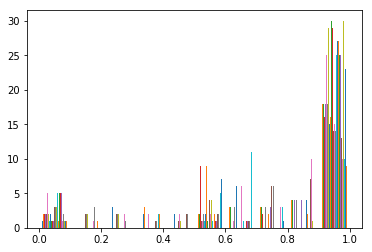

In [230]:
plt.hist(dist1);

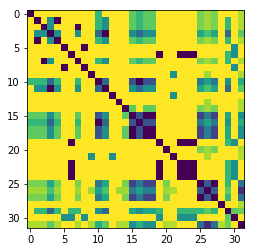

In [231]:
plt.imshow(dist1)

In [232]:
import scipy

In [233]:
cl2 = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(dist1), method='single')

In [234]:
cl2.shape

(31, 4)

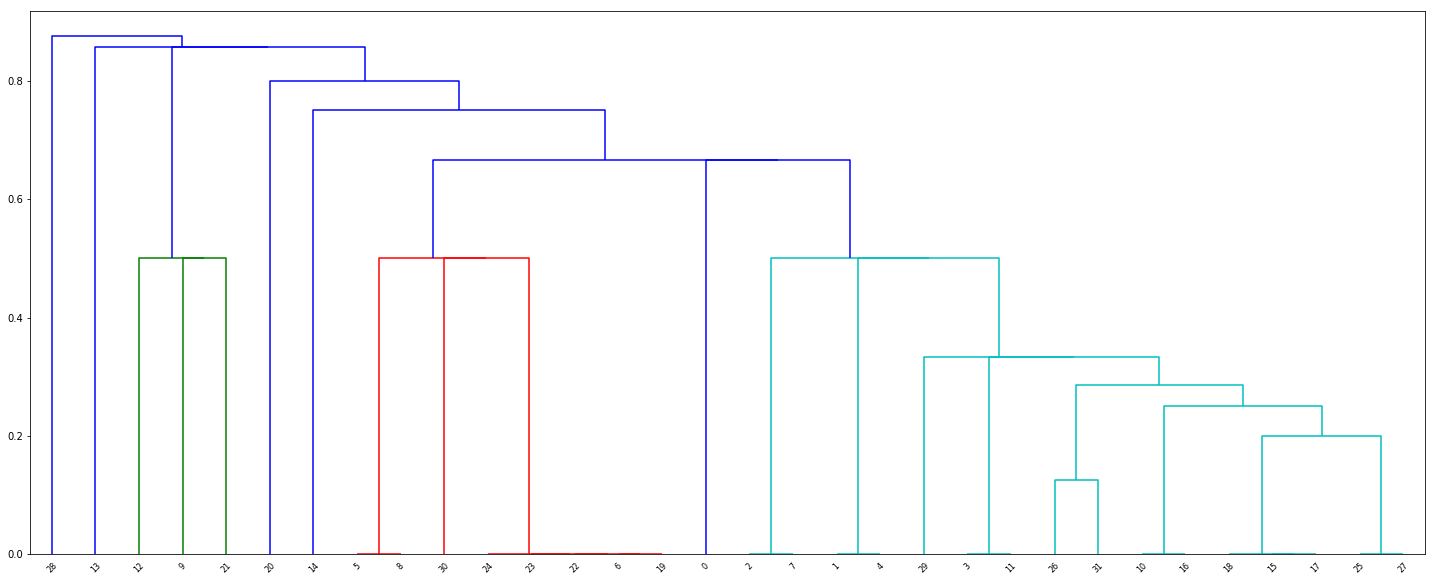

In [235]:
fig = plt.figure(figsize=(25, 10))
scipy.cluster.hierarchy.dendrogram(cl2);

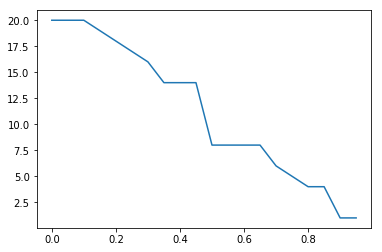

In [236]:
t_range = np.arange(0, 1, 0.05)
nr_clusters = [len(set(scipy.cluster.hierarchy.fcluster(cl2, t, criterion='distance'))) for t in t_range]
plt.plot(t_range, nr_clusters);

In [237]:
clusters = scipy.cluster.hierarchy.fcluster(cl2, 0.5, criterion='distance')

In [240]:
pd.Series(clusters).value_counts().head(10)

3    16
2     8
1     3
8     1
7     1
6     1
5     1
4     1
dtype: int64

In [241]:
nx.set_node_attributes(graph, {paths_nonzero_df.index[i]: int(clusters[i]) for i in range(len(clusters))}, name='cluster')

In [242]:
#nx.readwrite.gexf.write_gexf(graph, '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/network-clusters.gexf')
nx.readwrite.gexf.write_gexf(graph, '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/network-hr-clusters.gexf')